Name : Bhuva vrunda
Stream : AI&ML
Roll no: 03

# 1. Implement functions for encoding and decoding an image using the following methods:
A. Transform Coding (using DCT for forward transform)

B. Huffman Encoding

C. LZW Encoding

D. Run-Length Encoding

E. Arithmetic Coding

### 1.Transform Coding (Using DCT)


In [1]:
pip install numpy scipy Pillow

In [2]:
import numpy as np
from scipy.fftpack import dct, idct
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
# Function to perform DCT encoding on an image
def dct_encode(image_array):
    # Apply 2D DCT to the entire image
    dct_image = dct(dct(image_array.T, norm='ortho').T, norm='ortho')
    return dct_image

# Function to perform inverse DCT decoding to reconstruct the image
def dct_decode(dct_image):
    # Apply Inverse 2D DCT to reconstruct the image
    return idct(idct(dct_image.T, norm='ortho').T, norm='ortho')

In [4]:
def calculate_compression_ratio(original, compressed):
    original_size = original.size * 8  # size in bits (assuming 8 bits per pixel)
    compressed_size = np.count_nonzero(compressed) * 8  # size in bits
    return original_size / compressed_size

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))


In [6]:
# Load the image and convert to a grayscale numpy array
image = Image.open('image.png'
).convert('L')  # 'L' converts the image to grayscale
image_array = np.array(image)

# Perform DCT encoding and decoding
dct_encoded = dct_encode(image_array)
dct_reconstructed = dct_decode(dct_encoded)

# Clip values to be in the 0-255 range and convert to uint8
reconstructed_image_array = np.uint8(np.clip(dct_reconstructed, 0, 255))

In [7]:
# Calculate Compression Ratio
compression_ratio = calculate_compression_ratio(image_array, dct_encoded)
print(f"Compression Ratio: {compression_ratio:.2f}")

# Calculate RMSE
rmse = calculate_rmse(image_array, reconstructed_image_array)
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")


Compression Ratio: 1.00
Root Mean Square Error (RMSE): 0.43


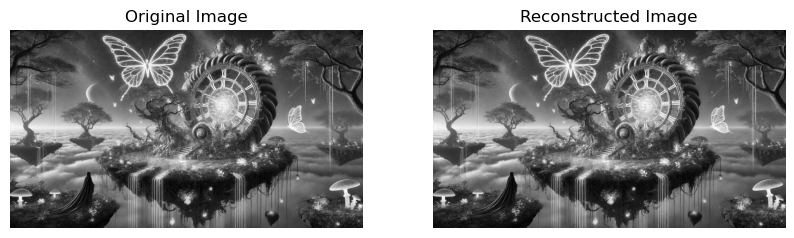

In [8]:
plt.figure(figsize=(10, 5))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(image_array, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Display the reconstructed image
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image_array, cmap='gray')
plt.title("Reconstructed Image")
plt.axis('off')

plt.show()


### 2. Huffman Encoding for Image Compression


In [9]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import heapq
from collections import defaultdict

In [10]:
class HuffmanNode:
    def __init__(self, symbol, freq):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

In [11]:
def build_huffman_tree(frequencies):
    heap = [HuffmanNode(symbol, freq) for symbol, freq in frequencies.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = HuffmanNode(None, node1.freq + node2.freq)
        merged.left = node1
        merged.right = node2
        heapq.heappush(heap, merged)
    return heap[0]


In [12]:
def generate_codes(node, code="", codebook=None):
    if codebook is None:
        codebook = {}
    if node is not None:
        if node.symbol is not None:
            codebook[node.symbol] = code
        generate_codes(node.left, code + "0", codebook)
        generate_codes(node.right, code + "1", codebook)
    return codebook

In [13]:
# Function to perform Huffman Encoding
def huffman_encode(image_array):
    # Calculate symbol frequencies
    frequencies = defaultdict(int)
    for value in image_array.flatten():
        frequencies[value] += 1

    # Build Huffman Tree and generate codes
    huffman_tree = build_huffman_tree(frequencies)
    huffman_codes = generate_codes(huffman_tree)

    # Encode the image
    encoded_image = "".join(huffman_codes[value] for value in image_array.flatten())
    return encoded_image, huffman_codes, len(image_array.flatten()) * 8


In [14]:
# Function to decode Huffman Encoded image
def huffman_decode(encoded_image, huffman_codes, original_shape):
    reverse_codes = {v: k for k, v in huffman_codes.items()}
    current_code = ""
    decoded_values = []

    for bit in encoded_image:
        current_code += bit
        if current_code in reverse_codes:
            decoded_values.append(reverse_codes[current_code])
            current_code = ""

    return np.array(decoded_values).reshape(original_shape)

In [15]:
# Function to calculate Compression Ratio
def calculate_compression_ratio_huffman(original_bits, encoded_bits):
    return original_bits / len(encoded_bits)


In [17]:
# Load the image and convert to a grayscale numpy array
image = Image.open('image.png').convert('L')
image_array = np.array(image)

# Perform Huffman Encoding and Decoding
encoded_image, huffman_codes, original_bits = huffman_encode(image_array)
decoded_image_array = huffman_decode(encoded_image, huffman_codes, image_array.shape)


In [18]:
# Calculate Compression Ratio
compression_ratio = calculate_compression_ratio_huffman(original_bits, encoded_image)
print(f"Compression Ratio: {compression_ratio:.2f}")

# Calculate RMSE
rmse = np.sqrt(np.mean((image_array - decoded_image_array) ** 2))
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")


Compression Ratio: 1.04
Root Mean Square Error (RMSE): 0.00


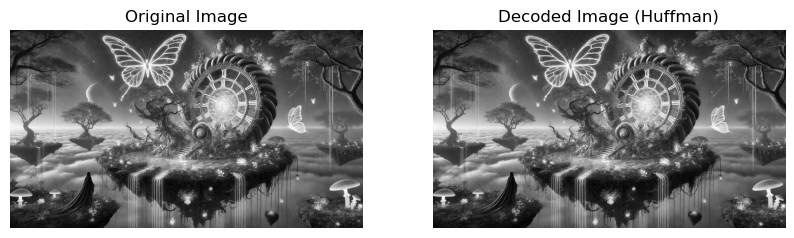

In [19]:
plt.figure(figsize=(10, 5))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(image_array, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Display the decoded image
plt.subplot(1, 2, 2)
plt.imshow(decoded_image_array, cmap='gray')
plt.title("Decoded Image (Huffman)")
plt.axis('off')

plt.show()

### 3. LZW Encoding for Image Compression


In [20]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [21]:
def lzw_encode(image_array):
    data = image_array.flatten()
    dictionary = {tuple([i]): i for i in range(256)}  # Initialize dictionary with single pixel values
    current_sequence = []
    encoded_data = []
    code = 256  # Next available code for new sequences

    for symbol in data:
        current_sequence.append(symbol)
        if tuple(current_sequence) not in dictionary:
            dictionary[tuple(current_sequence)] = code
            encoded_data.append(dictionary[tuple(current_sequence[:-1])])
            current_sequence = [symbol]  # Start new sequence
            code += 1

    # Encode the last sequence
    if current_sequence:
        encoded_data.append(dictionary[tuple(current_sequence)])

    original_bits = len(data) * 8  # Assuming 8 bits per pixel
    return encoded_data, dictionary, original_bits


In [22]:
def lzw_decode(encoded_data, dictionary):
    reverse_dictionary = {v: k for k, v in dictionary.items()}
    current_sequence = list(reverse_dictionary[encoded_data[0]])
    decoded_data = current_sequence.copy()

    for code in encoded_data[1:]:
        if code in reverse_dictionary:
            entry = list(reverse_dictionary[code])
        elif code == len(reverse_dictionary):
            entry = current_sequence + [current_sequence[0]]
        else:
            raise ValueError("Invalid LZW code encountered")

        decoded_data.extend(entry)
        current_sequence.append(entry[0])
        reverse_dictionary[len(reverse_dictionary)] = current_sequence
        current_sequence = entry

    return np.array(decoded_data)

In [24]:
image = Image.open('image.png').convert('L')
image_array = np.array(image)

# Perform LZW Encoding and Decoding
encoded_data, dictionary, original_bits = lzw_encode(image_array)
decoded_image_array = lzw_decode(encoded_data, dictionary).reshape(image_array.shape)



In [25]:
# Calculate Compression Ratio
compressed_size = len(encoded_data) * 16  # Assuming 16 bits per encoded symbol
compression_ratio = original_bits / compressed_size
print(f"Compression Ratio: {compression_ratio:.2f}")

# Calculate RMSE
rmse = np.sqrt(np.mean((image_array - decoded_image_array) ** 2))
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")

Compression Ratio: 1.26
Root Mean Square Error (RMSE): 0.00


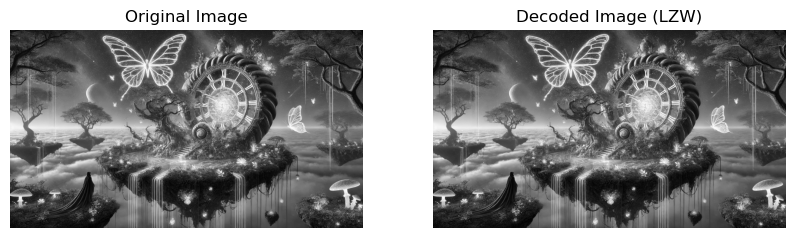

In [26]:
plt.figure(figsize=(10, 5))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(image_array, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Display the decoded image
plt.subplot(1, 2, 2)
plt.imshow(decoded_image_array, cmap='gray')
plt.title("Decoded Image (LZW)")
plt.axis('off')

plt.show()


### 4. Run-Length Encoding (RLE) for Image Compression


In [27]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [28]:
def rle_encode(image_array):
    data = image_array.flatten()
    encoded_data = []
    count = 1

    for i in range(1, len(data)):
        if data[i] == data[i - 1]:
            count += 1
        else:
            encoded_data.append((data[i - 1], count))
            count = 1

    # Append the last run
    encoded_data.append((data[-1], count))

    original_bits = len(data) * 8  # Assuming 8 bits per pixel
    return encoded_data, original_bits

In [29]:
def rle_decode(encoded_data, shape):
    decoded_data = []
    for value, count in encoded_data:
        decoded_data.extend([value] * count)
    return np.array(decoded_data).reshape(shape)

In [30]:
def calculate_compression_ratio_rle(original_bits, encoded_data):
    compressed_size = len(encoded_data) * (8 + 8)  # 8 bits for value and 8 bits for count
    return original_bits / compressed_size

In [32]:
image = Image.open('image.png').convert('L')
image_array = np.array(image)

# Perform Run-Length Encoding and Decoding
encoded_data, original_bits = rle_encode(image_array)
decoded_image_array = rle_decode(encoded_data, image_array.shape)

In [33]:
compression_ratio = calculate_compression_ratio_rle(original_bits, encoded_data)
print(f"Compression Ratio: {compression_ratio:.2f}")


rmse = np.sqrt(np.mean((image_array - decoded_image_array) ** 2))
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")

Compression Ratio: 0.57
Root Mean Square Error (RMSE): 0.00


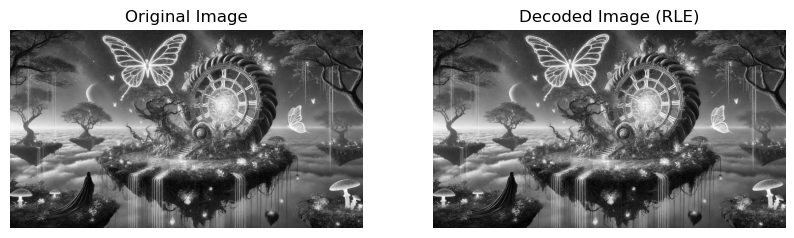

In [34]:
plt.figure(figsize=(10, 5))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(image_array, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Display the decoded image
plt.subplot(1, 2, 2)
plt.imshow(decoded_image_array, cmap='gray')
plt.title("Decoded Image (RLE)")
plt.axis('off')

plt.show()


### 5. Arithmetic Coding for Image Compression


In [10]:
from collections import Counter

def arithmetic_encode(data):
    # Frequency analysis
    frequency = Counter(data)
    total = sum(frequency.values())
    probabilities = {symbol: freq / total for symbol, freq in frequency.items()}
    
    # Create cumulative probability table
    cumulative_prob = {}
    cumulative = 0
    for symbol in sorted(probabilities.keys()):
        cumulative_prob[symbol] = cumulative
        cumulative += probabilities[symbol]
    
    low, high = 0.0, 1.0
    for symbol in data:
        range_width = high - low
        high = low + range_width * (cumulative_prob[symbol] + probabilities[symbol])
        low = low + range_width * cumulative_prob[symbol]

    return (low + high) / 2  # A number in the final interval

def arithmetic_decode(encoded_value, data_length, probabilities):
    # Create cumulative probability table
    cumulative_prob = {}
    cumulative = 0
    for symbol in sorted(probabilities.keys()):
        cumulative_prob[symbol] = cumulative
        cumulative += probabilities[symbol]

    decoded_data = []
    low, high = 0.0, 1.0
    for _ in range(data_length):
        range_width = high - low
        value = (encoded_value - low) / range_width
        for symbol, cum_prob in cumulative_prob.items():
            if cum_prob <= value < cum_prob + probabilities[symbol]:
                decoded_data.append(symbol)
                high = low + range_width * (cum_prob + probabilities[symbol])
                low = low + range_width * cum_prob
                break

    return decoded_data

# Example usage
data = [0, 1, 0, 2, 1, 0]  # Example pixel values
encoded_value = arithmetic_encode(data)
print("Encoded Value:", encoded_value)

# For decoding, we need the original data length and probabilities
probabilities = {0: 0.5, 1: 0.33, 2: 0.17}  # Example probabilities
decoded_data = arithmetic_decode(encoded_value, len(data), probabilities)
print("Decoded Data:", decoded_data)


Encoded Value: 0.3275462962962963
Decoded Data: [0, 1, 0, 2, 1, 0]
